In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install -q -U bitsandbytes transformers peft accelerate datasets scipy einops evaluate trl rouge_score

#You get a dependency error for irrelevant libraries which could be solved sure, but 
#that is not necessary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 25.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 106.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 47.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.3/318.3 kB 19.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sou

In [2]:
import bitsandbytes
import transformers
import peft
import accelerate
import datasets
import scipy
import einops
import evaluate
import trl
import rouge_score
from importlib.metadata import version

#rouge_score has no attribute __version__ --> we can get that information by using importlib

print("BitsAndBytes version:", bitsandbytes.__version__)
print("Transformers version:", transformers.__version__)
print("PEFT version:", peft.__version__)
print("Accelerate version:", accelerate.__version__)
print("Datasets version:", datasets.__version__)
print("Scipy version:", scipy.__version__)
print("Einops version:", einops.__version__)
print("Evaluate version:", evaluate.__version__)
print("TRL version:", trl.__version__)
print("Rouge Score version:", version("rouge-score"))

BitsAndBytes version: 0.45.2
Transformers version: 4.48.3
PEFT version: 0.14.0
Accelerate version: 1.3.0
Datasets version: 3.3.0
Scipy version: 1.15.2
Einops version: 0.8.1
Evaluate version: 0.4.3
TRL version: 0.15.0
Rouge Score version: 0.1.2


In [3]:
import os
# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"

In [4]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig
)
from tqdm import tqdm
from trl import SFTTrainer
import torch
import time
import pandas as pd
import numpy as np
from huggingface_hub import interpreter_login

interpreter_login()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



Enter your token (input will not be visible):  ········
Add token as git credential? (Y/n)  n


In [5]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [6]:
# https://huggingface.co/datasets/neil-code/dialogsum-test
huggingface_dataset_name = "neil-code/dialogsum-test"
dataset = load_dataset(huggingface_dataset_name)
dataset


README.md:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/441k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/447k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1999 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/499 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/499 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1999
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 499
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 499
    })
})

In [7]:
dataset['train'][0]



{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [8]:
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )
device_map = {"": 0}

In [9]:
model_name='TinyLlama/TinyLlama-1.1B-Chat-v1.0'
original_model = AutoModelForCausalLM.from_pretrained(model_name, 
                                                      device_map=device_map,
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [10]:
# https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa
tokenizer = AutoTokenizer.from_pretrained(model_name,trust_remote_code=True,padding_side="left",add_eos_token=True,add_bos_token=True,use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [11]:
print_gpu_utilization()


GPU memory occupied: 1224 MB.


In [12]:
eval_tokenizer = AutoTokenizer.from_pretrained(model_name, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

def gen(model,p, maxlen=100, sample=True):
    toks = eval_tokenizer(p, return_tensors="pt")
    res = model.generate(**toks.to("cuda"), max_new_tokens=maxlen, do_sample=sample,num_return_sequences=1,temperature=0.1,num_beams=1,top_p=0.95,).to('cpu')
    return eval_tokenizer.batch_decode(res,skip_special_tokens=True)

In [13]:
%%time
from transformers import set_seed
seed = 71
set_seed(seed)

index = 10

prompt = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

formatted_prompt = f"Instruct: Summarize the following conversation.\n{prompt}\nOutput:\n"
res = gen(original_model,formatted_prompt,100,)
#print(res[0])
output = res[0].split('Output:\n')[1]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{formatted_prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following conversation.
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
Output:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# attends Brian's birthday pa

In [14]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction','output')
    Then concatenate them using two newline characters 
    :param sample: Sample dictionnary
    """
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruct: Summarize the below conversation."
    RESPONSE_KEY = "### Output:"
    END_KEY = "### End"
    
    blurb = f"\n{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}"
    input_context = f"{sample['dialogue']}" if sample["dialogue"] else None
    response = f"{RESPONSE_KEY}\n{sample['summary']}"
    end = f"{END_KEY}"
    
    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    formatted_prompt = "\n\n".join(parts)
    sample["text"] = formatted_prompt

    return sample

In [15]:
# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length


def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )

In [16]:
from functools import partial

# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int,seed, dataset):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """
    
    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)#, batched=True)
    
    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=['id', 'topic', 'dialogue', 'summary'],
    )

    # Filter out samples that have input_ids exceeding max_length
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)
    
    # Shuffle dataset
    dataset = dataset.shuffle(seed=seed)

    return dataset

In [17]:
print_gpu_utilization()


GPU memory occupied: 1286 MB.


In [18]:
# ## Pre-process dataset
max_length = get_max_length(original_model)
print(max_length)

train_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['train'])
eval_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['validation'])

print(f"Shapes of the datasets:")
print(f"Training: {train_dataset.shape}")
print(f"Validation: {eval_dataset.shape}")
print(train_dataset)




Found max lenth: 2048
2048
Preprocessing dataset...


Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1999 [00:00<?, ? examples/s]

Preprocessing dataset...


Map:   0%|          | 0/499 [00:00<?, ? examples/s]

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/499 [00:00<?, ? examples/s]

Shapes of the datasets:
Training: (1999, 3)
Validation: (499, 3)
Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 1999
})


In [19]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 131164160
all model parameters: 615606272
percentage of trainable model parameters: 21.31%


In [20]:
print(original_model)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear4bit(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), e

In [21]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

config = LoraConfig(
    r=32, #Rank
    lora_alpha=32,
    target_modules=[
        'q_proj',
        'k_proj',
        'v_proj',
        'dense'
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

# 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
original_model.gradient_checkpointing_enable()

# 2 - Using the prepare_model_for_kbit_training method from PEFT
original_model = prepare_model_for_kbit_training(original_model)

peft_model = get_peft_model(original_model, config)

In [22]:
print(print_number_of_trainable_model_parameters(peft_model))
print(peft_model.device)
print(original_model.device)


trainable model parameters: 6127616
all model parameters: 621733888
percentage of trainable model parameters: 0.99%
cuda:0
cuda:0


In [23]:
output_dir = './peft-dialogue-summary-training/final-checkpoint'
import transformers

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    warmup_steps=1,
    per_device_train_batch_size=4,  # ✅ Increased for better GPU usage
    gradient_accumulation_steps=2,  # ✅ Reduced for speed
    max_steps=500,
    learning_rate=2e-4,
    optim="paged_adamw_8bit",
    logging_steps=50,  # ✅ Logs less often
    save_strategy="steps",
    save_steps=100,  # ✅ Saves less often
    evaluation_strategy="steps",
    eval_steps=50,  # ✅ Evaluates less often
    do_eval=True,
    gradient_checkpointing=False,  # ✅ Disabled for speed
    fp16=True,  # ✅ Enables mixed precision
    report_to="none",
    overwrite_output_dir=True,
    group_by_length=True,
    no_cuda = False,
    local_rank = -1
)


peft_model.config.use_cache = False

peft_trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=peft_training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#I had an issue here with the tensors being on two different GPUs when using the
#default T4 gpu x2 accelerator setting. I tried to fix this by doing some manual settings for the 
#tensors, but honestly it was too difficult given my timeframe so I decided to use a single p100 GPU 
#instead (this comes obviously at the cost of longer training but im free to do other studies)

peft_training_args.device
print(peft_model.device)
peft_trainer.train()


In [ ]:
from huggingface_hub import notebook_login
notebook_login()  # Enter your HF token

# Upload Model & Tokenizer
peft_model.push_to_hub("Pekkapuuma/tinyllama-dialogsum-finetuned-2")
tokenizer.push_to_hub("Pekkapuuma/tinyllama-dialogsum-finetuned-2")
#https://huggingface.co/Pekkapuuma/tinyllama-dialogsum-finetuned
#https://huggingface.co/Pekkapuuma/tinyllama-dialogsum-finetuned-2

In [ ]:
print_gpu_utilization()
del original_model
del peft_trainer
torch.cuda.empty_cache()
print_gpu_utilization()

#I ran this twice I guess the output is a bit messy now

In [24]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "Pekkapuuma/tinyllama-dialogsum-finetuned-2"
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, 
                                                      device_map='auto',
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/24.5M [00:00<?, ?B/s]

In [25]:
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

In [26]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "Pekkapuuma/tinyllama-dialogsum-finetuned-2",torch_dtype=torch.float16,is_trainable=False)

In [27]:
%%time
from transformers import set_seed
set_seed(seed)

index = 10
dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"

peft_model_res = gen(ft_model,prompt,50,)
peft_model_output = peft_model_res[0].split('Output:\n')[1]
print(peft_model_output)
prefix, success, result = peft_model_output.partition('#End')

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'PEFT MODEL:\n{prefix}')

 <|system|>

---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following conversation.
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
Output:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# attends Brian'

In [29]:
original_model = AutoModelForCausalLM.from_pretrained(model_name, 
                                                      device_map='auto',
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)

print(model_name)

TinyLlama/TinyLlama-1.1B-Chat-v1.0


In [30]:
import pandas as pd

dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    human_baseline_text_output = human_baseline_summaries[idx]
    prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"
    
    original_model_res = gen(original_model,prompt,100,)
    original_model_text_output = original_model_res[0].split('Output:\n')[1]
    
    peft_model_res = gen(ft_model,prompt,100,)
    peft_model_output = peft_model_res[0].split('Output:\n')[1]
    print(peft_model_output)
    peft_model_text_output, success, result = peft_model_output.partition('#End')
    

    original_model_summaries.append(original_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, peft_model_summaries))
 
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'peft_model_summaries'])
df

 <|system|>

 <|system|>

 <|system|>

 <|system|>

 <|system|>

 <|system|>

 <|system|>

 <|system|>

 <|system|>

 <|system|>



,human_baseline_summaries,original_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,\n<|user|>\nCan you please add some examples ...,<|system|>\n
1,In order to prevent employees from wasting tim...,\n<|user|>\nCan you please add some examples ...,<|system|>\n
2,Ms. Dawson takes a dictation for #Person1# abo...,\n<|user|>\nCan you please add some examples ...,<|system|>\n
3,#Person2# arrives late because of traffic jam....,\n<|user|>\nCan you please add some informati...,<|system|>\n
4,#Person2# decides to follow #Person1#'s sugges...,\n<|user|>\nCan you please add some informati...,<|system|>\n
5,#Person2# complains to #Person1# about the tra...,\n<|user|>\nCan you please add some informati...,<|system|>\n
6,#Person1# tells Kate that Masha and Hero get d...,\n<|user|>\nCan you please add some more deta...,<|system|>\n
7,#Person1# tells Kate that Masha and Hero are g...,\n<|user|>\nCan you please add some more deta...,<|system|>\n
8,#Person1# and Kate talk about the divorce betw...,\n<|user|>\nCan you please add some more deta...,<|system|>\n
9,#Person1# and Brian are at the birthday party ...,\n<|user|>\nCan you please add some more deta...,<|system|>\n


In [31]:
!pip install rouge_score

In [32]:
import evaluate

rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.15803384003695886, 'rouge2': 0.04027316148896696, 'rougeL': 0.11564181346863177, 'rougeLsum': 0.11603225732525894}
PEFT MODEL:
{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}


In [33]:
print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: -15.80%
rouge2: -4.03%
rougeL: -11.56%
rougeLsum: -11.60%


In [ ]:
#yes so the results are horrendous the model seems to have overfit to something
#This is odd given the number of training epochs is 2 and im using Autotokenizer and Autotrain
#with the setup that the course staff wanted. Weird



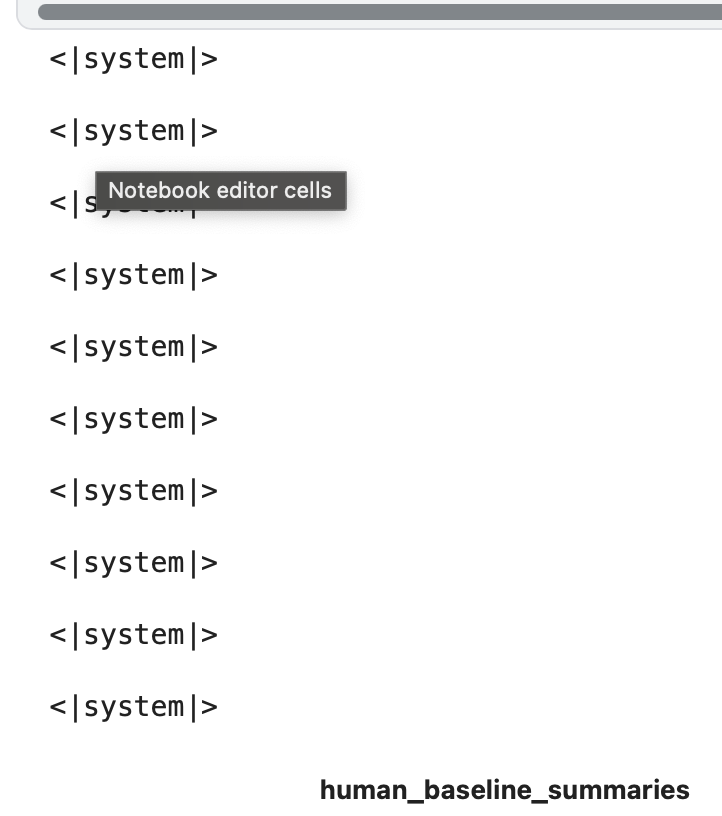